# Calculate the high vs low years for temperature, ice fraction and nutrietns on a point by point basis, then Plot the slope and intercept quarterly! 

##  Units: 
    1. Temperature ($^o$ C)
    2. Ice Fraction (unitless)
    3. NO$_3$ concentration (mmol m$^{-3}$)

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os

%matplotlib inline
from glob import glob
import dask
import esmlab
import pop_tools 
from statistics import mean

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

## High vs low temperature 

In [4]:
temp_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_TEMP.*.nc', recursive=True))
ds_01= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [5]:
%%time
temp_ds_inter = np.empty([62,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    temp_ds_inter[i,:,:,:] = ds_01.TEMP[x[i]:x[i]+12,0,:,:]

CPU times: user 9.57 s, sys: 9.81 s, total: 19.4 s
Wall time: 28.9 s


In [6]:
## Calculate climatology for each grid cell
temp_ao_clim = np.nanmean(temp_ds_inter,axis=0) # Size (12,180,360)

In [7]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
temp_arctic_anom = np.empty([62,12,180,360]) ; temp_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        temp_arctic_anom[:,:,latitude,longitude] = temp_ds_inter[:,:,latitude,longitude]-temp_ao_clim[:,latitude,longitude]

# Calculate the standard deviation from the year and months at each latitude.. 
err_ao = np.nanstd(temp_arctic_anom,axis=(0,1))

CPU times: user 490 ms, sys: 169 ms, total: 660 ms
Wall time: 701 ms


## Calculate the cold vs the warm years for all the latitudes and longitudes.. 
    1. We have the anonmalies for each latitude and longitude
    2. We have the standard error for each latitude and each longitude 
    3. we want to select the warm and cold years from each latitude and each longitude... 

In [8]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
cold_years_arctic = {}
warm_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
cold_years_arctic = multi_dict(2, int)
warm_years_arctic = multi_dict(2, int)
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        cold_years_arctic[latitude][longitude] = np.where(np.nanmean(temp_arctic_anom[:,:,latitude, longitude],axis=1) < -(err_ao[latitude, longitude]/2))
        warm_years_arctic[latitude][longitude] = np.where(np.nanmean(temp_arctic_anom[:,:,latitude, longitude],axis=1) > (err_ao[latitude, longitude]/2))

## Now make sure that this works and can be used!! 

In [9]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
cold_years_temp = np.empty([12,180,360]) ; cold_years_temp[:] = np.nan
warm_years_temp = np.empty([12,180,360]) ; warm_years_temp[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        cold_years_temp[:,latitude,longitude] = np.nanmean(temp_ds_inter[cold_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        warm_years_temp[:,latitude,longitude] = np.nanmean(temp_ds_inter[warm_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

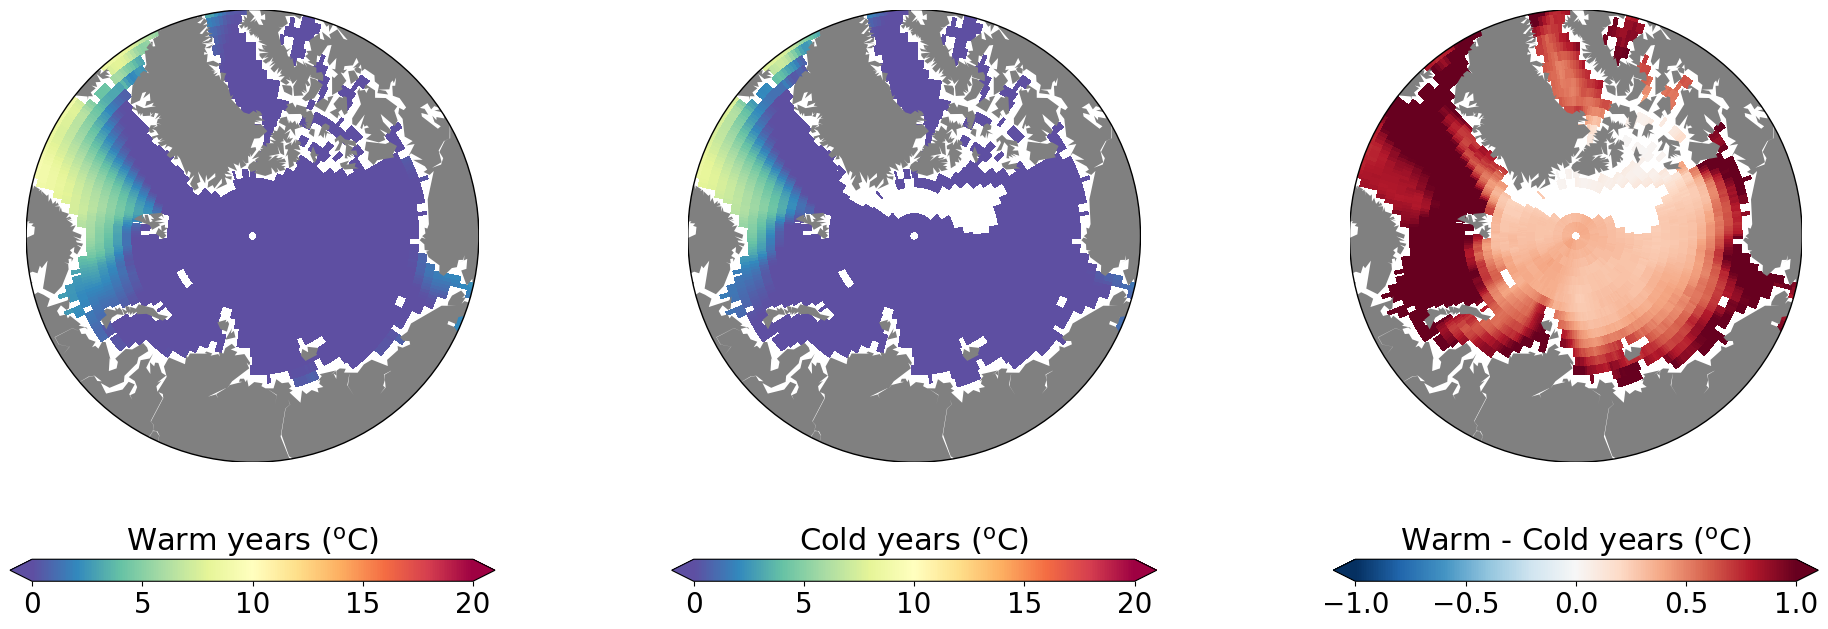

In [10]:
fig = plt.figure(figsize=(20, 20))
lat = ds_01.lat

# Temperature 
ax = fig.add_subplot(3, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cold, lon = add_cyclic_point(np.nanmean(cold_years_temp,axis=0), coord=ds_01.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,cold,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Cold years ($^oC$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

ax = fig.add_subplot(3, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
warm, lon = add_cyclic_point(np.nanmean(warm_years_temp,axis=0), coord=ds_01.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,warm,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Warm years ($^oC$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


ax = fig.add_subplot(3, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,warm-cold,cmap='RdBu_r', vmin = -1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Warm - Cold years ($^oC$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

plt.tight_layout()

## Now check Seasonally differences 

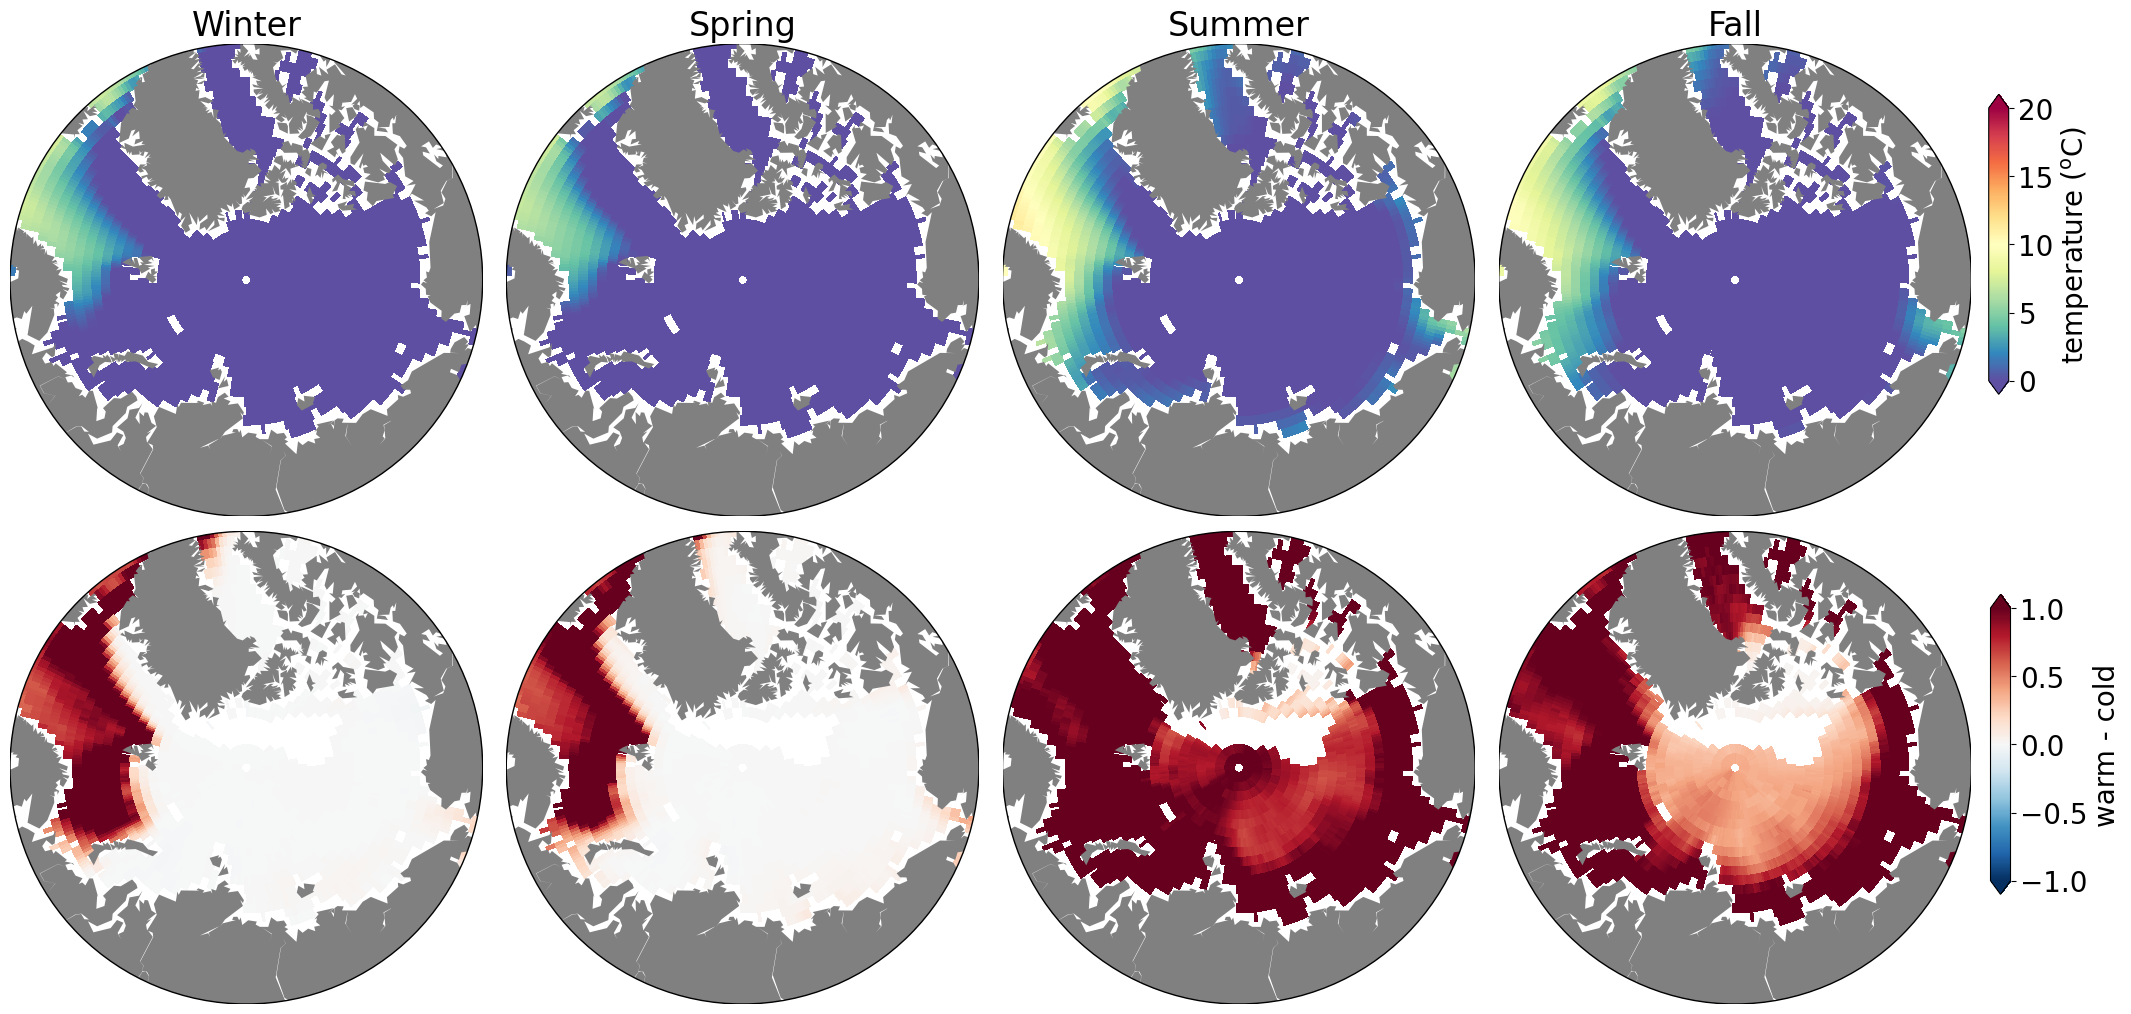

In [11]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))
lat = ds_01.lat

# Winter 
ax = fig.add_subplot(4, 4, 1)
winter, lon = add_cyclic_point(np.nanmean(temp_ds_inter[:,list(range(2)) + [-1],:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Winter', fontsize =24)

# Spring 
ax = fig.add_subplot(4, 4, 2)
spring, lon = add_cyclic_point(np.nanmean(temp_ds_inter[:,2:5,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Spring', fontsize =24)

# Summer 
ax = fig.add_subplot(4, 4, 3)
summer, lon = add_cyclic_point(np.nanmean(temp_ds_inter[:,5:8,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Summer', fontsize =24)

# Fall 
ax = fig.add_subplot(4, 4, 4)
fall, lon = add_cyclic_point(np.nanmean(temp_ds_inter[:,8:11,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, fall, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Fall', fontsize =24)

cbar_ax = fig.add_axes([0.999, 0.8, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel('temperature ($^o$C)', fontsize=20)

########## Differences!!! ############
vminn = -1
vmaxx = 1
##########################################



# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 5)
winter_temp_diff = np.nanmean(warm_years_temp[list(range(2)) + [-1],:,:],axis=0) - np.nanmean(cold_years_temp[list(range(2)) + [-1],:,:],axis=0)
w_diff, lon = add_cyclic_point(winter_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 6)
spring_temp_diff = ((np.nanmean(warm_years_temp[2:5,:,:], axis=(0))-np.nanmean(cold_years_temp[2:5,:,:], axis=(0))))
sp_diff, lon = add_cyclic_point(spring_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 7)
summer_temp_diff = ((np.nanmean(warm_years_temp[5:8,:,:], axis=(0))-np.nanmean(cold_years_temp[5:8,:,:], axis=(0))))
s_diff, lon = add_cyclic_point(summer_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);


# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 8)
fall_temp_diff = ((np.nanmean(warm_years_temp[8:11,:,:], axis=(0))-np.nanmean(cold_years_temp[8:11,:,:], axis=(0))))
f_diff, lon = add_cyclic_point(fall_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

cbar_ax = fig.add_axes([0.9999, 0.55, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel('warm - cold', fontsize=20)
plt.tight_layout()

## ICE FRACTION

In [12]:
temp_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds_02= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [13]:
ECOSYS_IFRAC_ds_inter = np.empty([62,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds_02.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

In [14]:
## Calculate climatology for each grid cell
ice_ao_clim = np.nanmean(ECOSYS_IFRAC_ds_inter,axis=0) # Size (12,180,360)

In [15]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
ice_arctic_anom = np.empty([62,12,180,360]) ; ice_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        ice_arctic_anom[:,:,latitude,longitude] = ECOSYS_IFRAC_ds_inter[:,:,latitude,longitude]-ice_ao_clim[:,latitude,longitude]

# Calculate the standard deviation from the year and months at each latitude.. 
err_ao = np.nanstd(ice_arctic_anom,axis=(0,1))

CPU times: user 493 ms, sys: 195 ms, total: 688 ms
Wall time: 693 ms


In [16]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_ice_years_arctic = {}
high_ice_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_ice_years_arctic = multi_dict(2, int)
high_ice_years_arctic = multi_dict(2, int)
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_ice_years_arctic[latitude][longitude] = np.where(np.nanmean(ice_arctic_anom[:,:,latitude, longitude],axis=1) < -(err_ao[latitude, longitude]/2))
        high_ice_years_arctic[latitude][longitude] = np.where(np.nanmean(ice_arctic_anom[:,:,latitude, longitude],axis=1) > (err_ao[latitude, longitude]/2))

In [ ]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_ice_years_temp = np.empty([12,180,360]) ; low_ice_years_temp[:] = np.nan
high_ice_years_temp = np.empty([12,180,360]) ; high_ice_years_temp[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds_inter[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds_inter[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1)) 

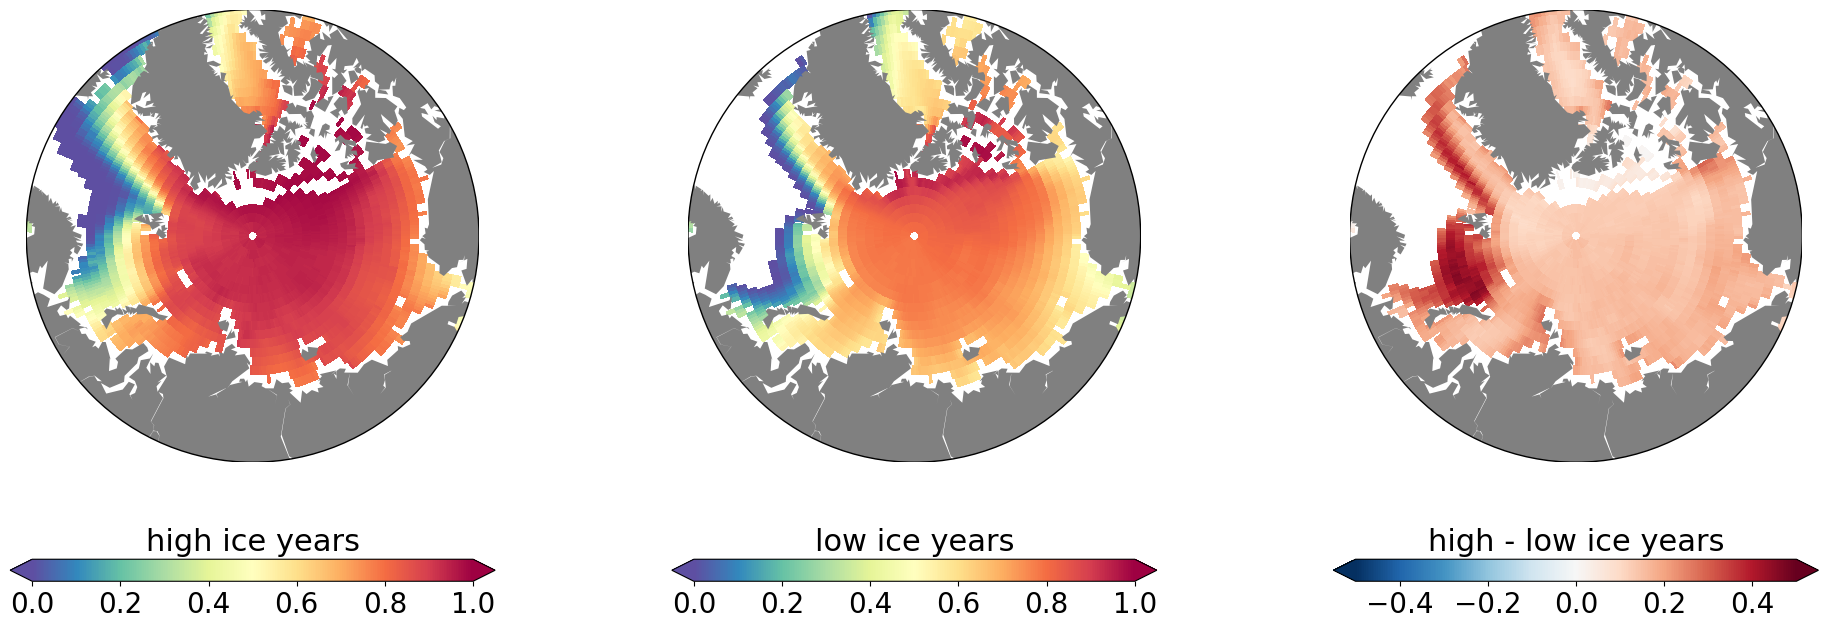

In [18]:
fig = plt.figure(figsize=(20, 20))
lat = ds_02.lat

# Temperature 
ax = fig.add_subplot(3, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cold, lon = add_cyclic_point(np.nanmean(low_ice_years_temp,axis=0), coord=ds_02.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,cold,cmap='Spectral_r',vmin=0,vmax=1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('low ice years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

ax = fig.add_subplot(3, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
warm, lon = add_cyclic_point(np.nanmean(high_ice_years_temp,axis=0), coord=ds_02.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,warm,cmap='Spectral_r',vmin=0,vmax=1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high ice years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


ax = fig.add_subplot(3, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,warm-cold,cmap='RdBu_r', vmin = -0.5, vmax = 0.5)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high - low ice years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

plt.tight_layout()

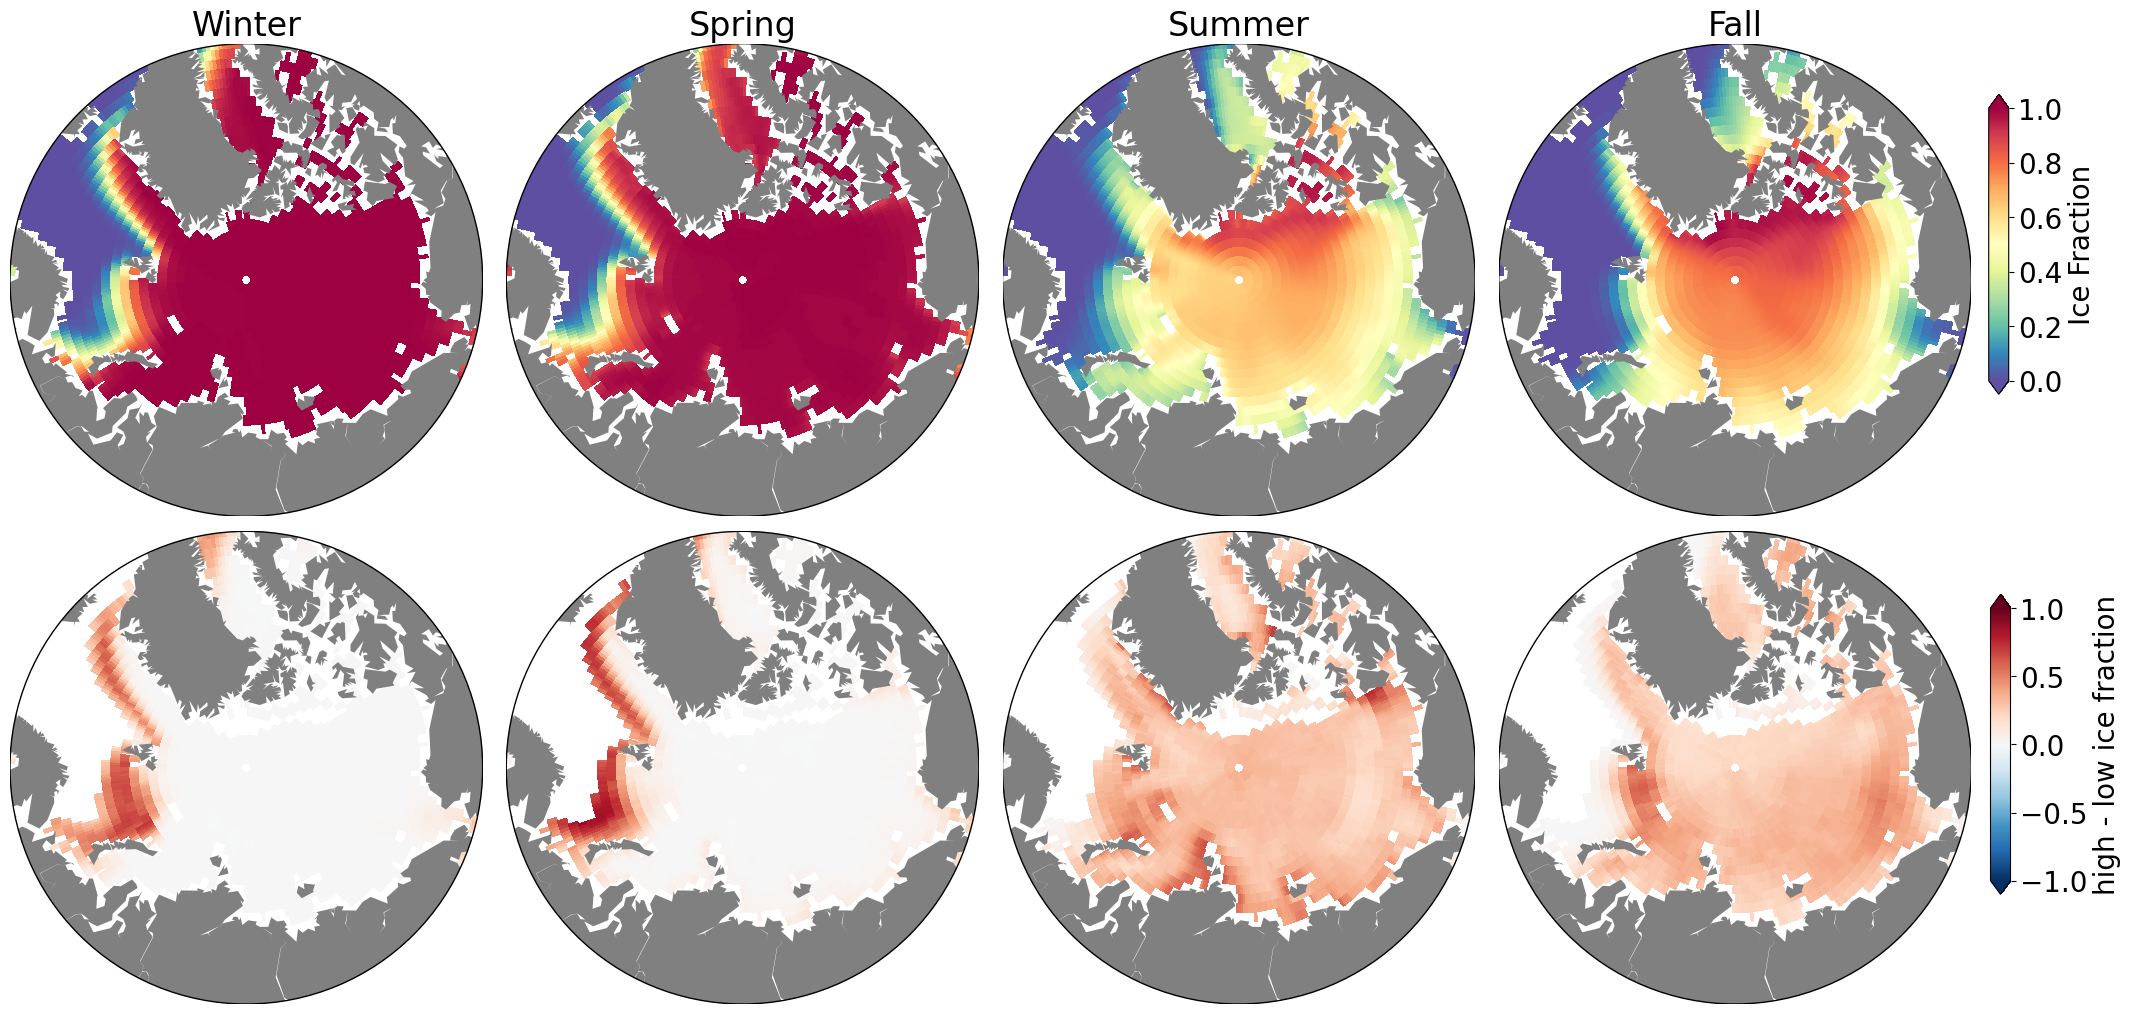

In [19]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))
lat = ds_01.lat

# Winter 
ax = fig.add_subplot(4, 4, 1)
winter, lon = add_cyclic_point(np.nanmean(ECOSYS_IFRAC_ds_inter[:,list(range(2)) + [-1],:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 0, vmax = 1);
ax.set_title('Winter', fontsize =24)

# Spring 
ax = fig.add_subplot(4, 4, 2)
spring, lon = add_cyclic_point(np.nanmean(ECOSYS_IFRAC_ds_inter[:,2:5,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 0, vmax = 1);
ax.set_title('Spring', fontsize =24)

# Summer 
ax = fig.add_subplot(4, 4, 3)
summer, lon = add_cyclic_point(np.nanmean(ECOSYS_IFRAC_ds_inter[:,5:8,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 0, vmax = 1);
ax.set_title('Summer', fontsize =24)

# Fall 
ax = fig.add_subplot(4, 4, 4)
fall, lon = add_cyclic_point(np.nanmean(ECOSYS_IFRAC_ds_inter[:,8:11,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, fall, cmap='Spectral_r', vmin = 0, vmax = 1);
ax.set_title('Fall', fontsize =24)

cbar_ax = fig.add_axes([0.999, 0.8, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel('Ice Fraction', fontsize=20)

########## Differences!!! ############
vminn = -1
vmaxx = 1
##########################################



# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 5)
winter_temp_diff = np.nanmean(high_ice_years_temp[list(range(2)) + [-1],:,:],axis=0) - np.nanmean(low_ice_years_temp[list(range(2)) + [-1],:,:],axis=0)
w_diff, lon = add_cyclic_point(winter_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 6)
spring_temp_diff = ((np.nanmean(high_ice_years_temp[2:5,:,:], axis=(0))-np.nanmean(low_ice_years_temp[2:5,:,:], axis=(0))))
sp_diff, lon = add_cyclic_point(spring_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 7)
summer_temp_diff = ((np.nanmean(high_ice_years_temp[5:8,:,:], axis=(0))-np.nanmean(low_ice_years_temp[5:8,:,:], axis=(0))))
s_diff, lon = add_cyclic_point(summer_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);


# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 8)
fall_temp_diff = ((np.nanmean(high_ice_years_temp[8:11,:,:], axis=(0))-np.nanmean(low_ice_years_temp[8:11,:,:], axis=(0))))
f_diff, lon = add_cyclic_point(fall_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

cbar_ax = fig.add_axes([0.9999, 0.55, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel('high - low ice fraction', fontsize=20)
plt.tight_layout()

## NO$_3$ Years

In [20]:
NO3_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_NO3*.nc', recursive=True))
ds_03= xr.open_mfdataset(NO3_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [21]:
%%time
NO3_ds_inter = np.empty([62,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    NO3_ds_inter[i,:,:,:] = ds_03.NO3[x[i]:x[i]+12,0,:,:]

CPU times: user 10.4 s, sys: 11.9 s, total: 22.3 s
Wall time: 32.7 s


In [22]:
## Calculate climatology for each grid cell
no3_ao_clim = np.nanmean(NO3_ds_inter,axis=0) # Size (12,180,360)

In [23]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
no3_arctic_anom = np.empty([62,12,180,360]) ; no3_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        no3_arctic_anom[:,:,latitude,longitude] = NO3_ds_inter[:,:,latitude,longitude]-no3_ao_clim[:,latitude,longitude]

# Calculate the standard deviation from the year and months at each latitude.. 
err_ao = np.nanstd(no3_arctic_anom,axis=(0,1))

CPU times: user 557 ms, sys: 365 ms, total: 922 ms
Wall time: 943 ms


In [24]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_no3_years_arctic = {}
high_no3_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_no3_years_arctic = multi_dict(2, int)
high_no3_years_arctic = multi_dict(2, int)
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_no3_years_arctic[latitude][longitude] = np.where(np.nanmean(no3_arctic_anom[:,:,latitude, longitude],axis=1) < -(err_ao[latitude, longitude]/2))
        high_no3_years_arctic[latitude][longitude] = np.where(np.nanmean(no3_arctic_anom[:,:,latitude, longitude],axis=1) > (err_ao[latitude, longitude]/2))

In [25]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_temp = np.empty([12,180,360]) ; low_no3_years_temp[:] = np.nan
high_no3_years_temp = np.empty([12,180,360]) ; high_no3_years_temp[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_no3_years_temp[:,latitude,longitude] = np.nanmean(NO3_ds_inter[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_no3_years_temp[:,latitude,longitude] = np.nanmean(NO3_ds_inter[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

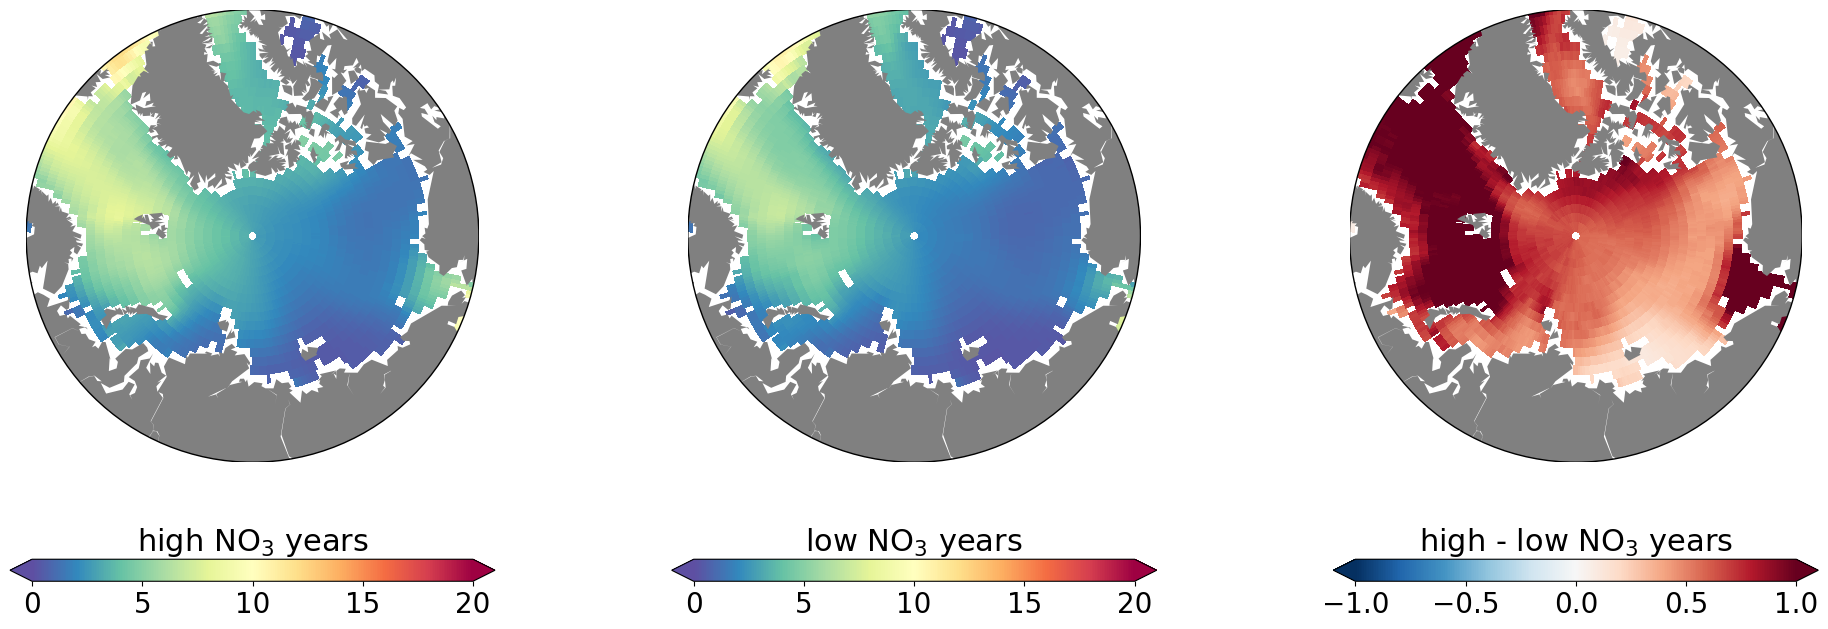

In [26]:
fig = plt.figure(figsize=(20, 20))
lat = ds_03.lat

# Temperature 
ax = fig.add_subplot(3, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cold, lon = add_cyclic_point(np.nanmean(low_no3_years_temp,axis=0), coord=ds_03.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,cold,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('low NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

ax = fig.add_subplot(3, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
warm, lon = add_cyclic_point(np.nanmean(high_no3_years_temp,axis=0), coord=ds_03.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,warm,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


ax = fig.add_subplot(3, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,warm-cold,cmap='RdBu_r', vmin = -1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high - low NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

plt.tight_layout()

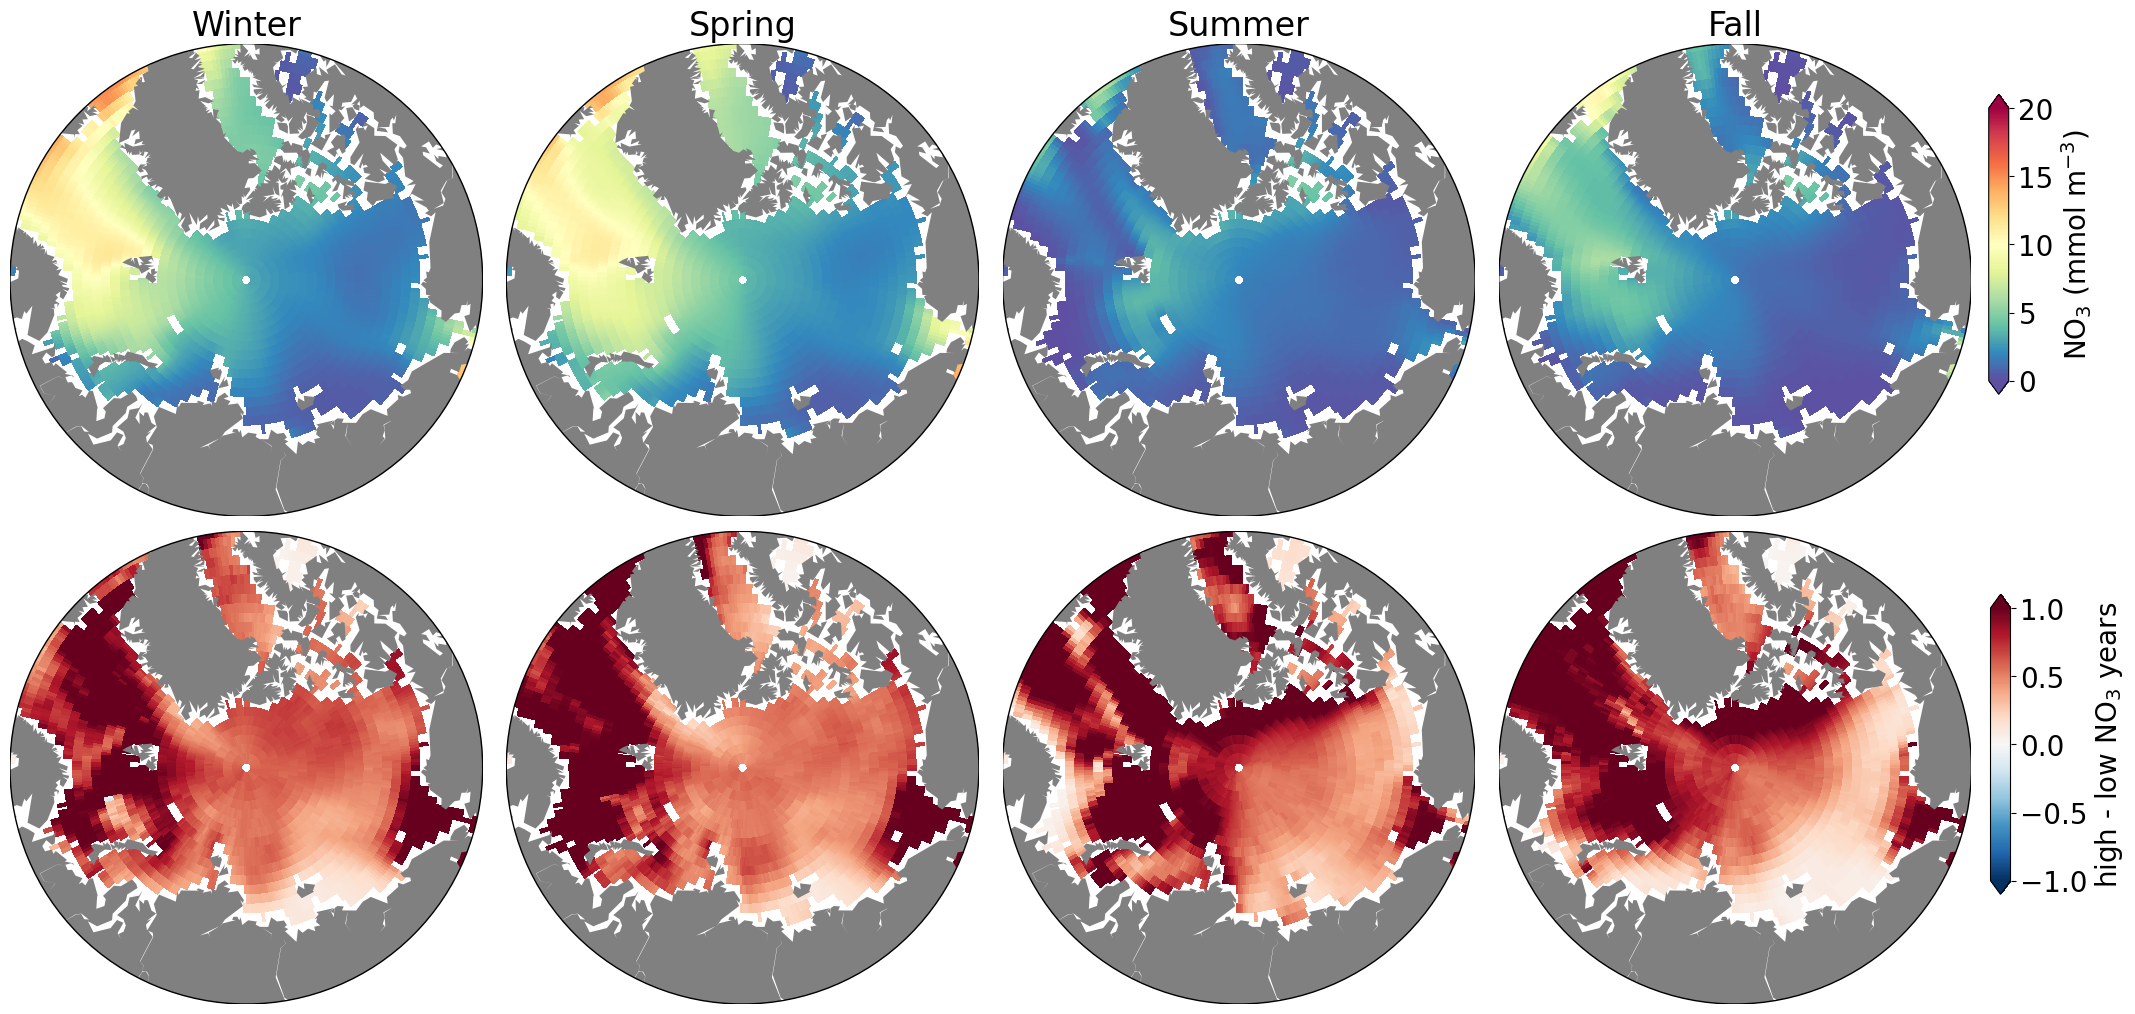

In [27]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))
lat = ds_01.lat

# Winter 
ax = fig.add_subplot(4, 4, 1)
winter, lon = add_cyclic_point(np.nanmean(NO3_ds_inter[:,list(range(2)) + [-1],:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Winter', fontsize =24)

# Spring 
ax = fig.add_subplot(4, 4, 2)
spring, lon = add_cyclic_point(np.nanmean(NO3_ds_inter[:,2:5,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Spring', fontsize =24)

# Summer 
ax = fig.add_subplot(4, 4, 3)
summer, lon = add_cyclic_point(np.nanmean(NO3_ds_inter[:,5:8,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Summer', fontsize =24)

# Fall 
ax = fig.add_subplot(4, 4, 4)
fall, lon = add_cyclic_point(np.nanmean(NO3_ds_inter[:,8:11,:,:],axis=(0,1)), coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, fall, cmap='Spectral_r', vmin = 0, vmax = 20);
ax.set_title('Fall', fontsize =24)

cbar_ax = fig.add_axes([0.999, 0.8, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)', fontsize=20)

########## Differences!!! ############
vminn = -1
vmaxx = 1
##########################################



# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 5)
winter_temp_diff = np.nanmean(high_no3_years_temp[list(range(2)) + [-1],:,:],axis=0) - np.nanmean(low_no3_years_temp[list(range(2)) + [-1],:,:],axis=0)
w_diff, lon = add_cyclic_point(winter_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 6)
spring_temp_diff = ((np.nanmean(high_no3_years_temp[2:5,:,:], axis=(0))-np.nanmean(low_no3_years_temp[2:5,:,:], axis=(0))))
sp_diff, lon = add_cyclic_point(spring_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 7)
summer_temp_diff = ((np.nanmean(high_no3_years_temp[5:8,:,:], axis=(0))-np.nanmean(low_no3_years_temp[5:8,:,:], axis=(0))))
s_diff, lon = add_cyclic_point(summer_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);


# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 8)
fall_temp_diff = ((np.nanmean(high_no3_years_temp[8:11,:,:], axis=(0))-np.nanmean(low_no3_years_temp[8:11,:,:], axis=(0))))
f_diff, lon = add_cyclic_point(fall_temp_diff, coord=ds_01.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

cbar_ax = fig.add_axes([0.9999, 0.55, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel('high - low NO$_3$ years', fontsize=20)
plt.tight_layout()

## Import slope and intercept 

In [36]:
ypp_surface_62yr = np.load('/glade/scratch/gabyn/SPECTRA/GNG595_npy_files/ypp_surface_62yr_try2.npy')

In [56]:
time = np.arange(0,63,1)
month = np.arange(0,12,1)

In [54]:
campaign = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
newNCDFfiles = sorted(glob(f'{campaign}/GNG595_clim_1990-2009_*.nc', recursive=True),
                      key=numericalSort)
ds = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

# This has to be regridded to a 180 by 360 grid... 
## 1. Convert this into an nc file. 
    size_abundance_relationship = xr.DataArray(ypp_surface_62yr[:,:,:,:,0], coords={'time':time,'month':month,'TLAT':ds.TLAT[:,0],  'TLONG':ds.TLONG[0,:]},
                                           dims=['time','month', 'nlat', 'nlon'])
    size_abundance_relationship = size_abundance_relationship.to_dataset(name='sar_surface_62yr_slope')
    size_abundance_relationship['sar_surface_62yr_intercept'] = xr.DataArray(ypp_surface_62yr[:,:,:,:,1], coords={'time':time,'month':month,'TLAT':ds.TLAT[:,0],'TLONG':ds.TLONG[0,:]},
                                           dims=['time','month', 'nlat', 'nlon'])
        
## 2. Save under '/glade/u/home/gabyn/scratch/SPECTRA/nc_files' 
    size_abundance_relationship.to_netcdf('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/size_abundance_relationship.nc');
        
## 3. Regrid from that nc file (you can do this in bash)
SLOPE 

    * cd /glade/u/home/gabyn/scratch/SPECTRA/nc_files'
    * ncatted -a coordinates,sar_surface_62yr_slope,c,c,"TLONG TLAT" size_abundance_relationship.nc
    * cdo remapbil,r360x180 -selname,sar_surface_62yr_slope size_abundance_relationship.nc size_abundance_relationship_slope.nc
    * cdo sellonlatbox,-180,180,-89.5,89.5 size_abundance_relationship_slope.nc regrid_size_abundance_relationship_slope.nc

INTERCEPT 

    * ncatted -a coordinates,sar_surface_62yr_intercept,c,c,"TLONG TLAT" size_abundance_relationship.nc
    * cdo remapbil,r360x180 -selname,sar_surface_62yr_intercept size_abundance_relationship.nc size_abundance_relationship_intercept.nc
    * cdo sellonlatbox,-180,180,-89.5,89.5 size_abundance_relationship_intercept.nc regrid_size_abundance_relationship_intercept.nc

## Step 4. Import regrided slope and intercept 

In [64]:
ds_01 = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/size_abundance_relationship_slope.nc')
ds_02 = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/size_abundance_relationship_intercept.nc')

		NC4_inq_var_all: ncid 0x460000 varid 0
		NC4_inq_var_all: ncid 0x460000 varid 0
		NC4_inq_dim: ncid 0x460000 dimid 0
		NC4_inq_var_all: ncid 0x460000 varid 0
		NC4_inq_var_all: ncid 0x460000 varid 0
		NC4_inq_dim: ncid 0x460000 dimid 0
		NC4_inq_dim: ncid 0x460000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_var_all: ncid 0x460000 varid 0
		nc_inq_attname: ncid 0x460000 varid 0 attnum 0
		nc_inq_attname: ncid 0x460000 varid 0 attnum 1
		nc_inq_attname: ncid 0x460000 varid 0 attnum 2
		nc_inq_attname: ncid 0x460000 varid 0 attnum 3
		NC4_inq_att: ncid 0x460000 varid 0 name standard_name
			nc4_get_att: ncid 0x460000 varid 0 name standard_name attnum -1 mem_type 0
			nc4_get_att: ncid 0x460000 varid 0 name standard_name attnum -1 mem_type 2
		NC4_inq_att: ncid 0x460000 varid 0 name units
			nc4_get_att: ncid 0x460000 varid 0 name units attnum -1 mem_type 0
			nc4_get_att: ncid 0x460000 varid 0 name units attnum -1 mem_type 2
		NC4_inq_att: ncid 0x460000 varid 0 name calen

In [92]:
# any values that are 0 make them NaN
slope = np.array(ds_01.sar_surface_62yr_slope[1::,:,:,:])
intercept = np.array(ds_02.sar_surface_62yr_intercept[1::,:,:,:])

		NC4_inq_var_all: ncid 0x460000 varid 4
		NC4_inq_var_all: ncid 0x460000 varid 4
		NC4_inq_dim: ncid 0x460000 dimid 0
		NC4_inq_dim: ncid 0x460000 dimid 3
		NC4_inq_dim: ncid 0x460000 dimid 2
		NC4_inq_dim: ncid 0x460000 dimid 1
		NC4_inq_dim: ncid 0x460000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x460000 dimid 3
		NC4_inq_dim: ncid 0x460000 dimid 2
		NC4_inq_dim: ncid 0x460000 dimid 1
		NC4_inq_var_all: ncid 0x460000 varid 4
		NC4_inq_var_all: ncid 0x460000 varid 4
		NC4_inq_dim: ncid 0x460000 dimid 0
		NC4_inq_dim: ncid 0x460000 dimid 3
		NC4_inq_dim: ncid 0x460000 dimid 2
		NC4_inq_dim: ncid 0x460000 dimid 1
		NC4_inq_var_all: ncid 0x460000 varid 4
		NC4_inq_var_all: ncid 0x460000 varid 4
		NC4_inq_dim: ncid 0x460000 dimid 0
		NC4_inq_dim: ncid 0x460000 dimid 3
		NC4_inq_dim: ncid 0x460000 dimid 2
		NC4_inq_dim: ncid 0x460000 dimid 1
		NC4_inq_var_all: ncid 0x460000 varid 4
			NC4_get_vars: var->hdr.name sar_surface_62yr_slope mem_nc_type 6
		NC4_inq_di

In [96]:
slope[slope==0]=np.nan

## NO$_3$, Temp and Ice Fraction

In [97]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years = np.empty([12,180,360]) ; low_no3_years[:] = np.nan
high_no3_years = np.empty([12,180,360]) ; high_no3_years[:] = np.nan

low_temp_years = np.empty([12,180,360]) ; low_temp_years[:] = np.nan
high_temp_years = np.empty([12,180,360]) ; high_temp_years[:] = np.nan

low_ice_years = np.empty([12,180,360]) ; low_ice_years[:] = np.nan
high_ice_years = np.empty([12,180,360]) ; high_ice_years[:] = np.nan


for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_no3_years[:,latitude,longitude] = np.nanmean(slope[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_no3_years[:,latitude,longitude] = np.nanmean(slope[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1)) 
        
        low_temp_years[:,latitude,longitude] = np.nanmean(slope[cold_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_temp_years[:,latitude,longitude] = np.nanmean(slope[warm_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        
        low_ice_years[:,latitude,longitude] = np.nanmean(slope[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_ice_years[:,latitude,longitude] = np.nanmean(slope[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
 

CPU times: user 2.8 s, sys: 7.36 ms, total: 2.81 s
Wall time: 2.87 s


## import the ice fraction information

In [98]:
ice_frac_summer = np.nanmean(ECOSYS_IFRAC_ds_inter[:,5:8,:,:],axis=1)
ice_frac_spring = np.nanmean(ECOSYS_IFRAC_ds_inter[:,2:5,:,:],axis=1)
ice_frac_winter = np.nanmean(ECOSYS_IFRAC_ds_inter[:,list(range(2)) + [-1],:,:],axis=1)
ice_frac_fall = np.nanmean(ECOSYS_IFRAC_ds_inter[:,8:11,:,:],axis=1)

In [99]:
# This is loading the low and high temp, no3 and ice years when averging the whole Arctic... 
# I tried to do it grid by grid, but ice fraction works better when you average throughout the whole Arctic. 
high_ice_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_ice_years_arctic.npy')
low_ice_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_ice_years_arctic.npy')

high_no3_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_no3_years_arctic.npy')
low_no3_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_no3_years_arctic.npy')

high_temp_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_temp_years_arctic.npy')
low_temp_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_temp_years_arctic.npy')

In [100]:
## NO3
low_no3_years_summer_ice = ice_frac_summer[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_summer_ice = ice_frac_summer[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

low_no3_years_spring_ice = ice_frac_spring[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_spring_ice= ice_frac_spring[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

low_no3_years_fall_ice = ice_frac_fall[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_fall_ice = ice_frac_fall[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

low_no3_years_winter_ice = ice_frac_winter[low_no3_years_arctic_avg,:,:] # 1/2 standard deviation 
high_no3_years_winter_ice = ice_frac_winter[high_no3_years_arctic_avg,:,:] # 1/2 standard deviation 

## ice
low_ice_years_summer_ice = ice_frac_summer[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_summer_ice = ice_frac_summer[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

low_ice_years_spring_ice = ice_frac_spring[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_spring_ice= ice_frac_spring[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

low_ice_years_fall_ice = ice_frac_fall[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_fall_ice = ice_frac_fall[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

low_ice_years_winter_ice = ice_frac_winter[low_ice_years_arctic_avg,:,:] # 1/2 standard deviation 
high_ice_years_winter_ice = ice_frac_winter[high_ice_years_arctic_avg,:,:] # 1/2 standard deviation 

## temperature
low_temp_years_summer_ice = ice_frac_summer[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_summer_ice = ice_frac_summer[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

low_temp_years_spring_ice = ice_frac_spring[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_spring_ice= ice_frac_spring[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

low_temp_years_fall_ice = ice_frac_fall[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_fall_ice = ice_frac_fall[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

low_temp_years_winter_ice = ice_frac_winter[low_temp_years_arctic_avg,:,:] # 1/2 standard deviation 
high_temp_years_winter_ice = ice_frac_winter[high_temp_years_arctic_avg,:,:] # 1/2 standard deviation 

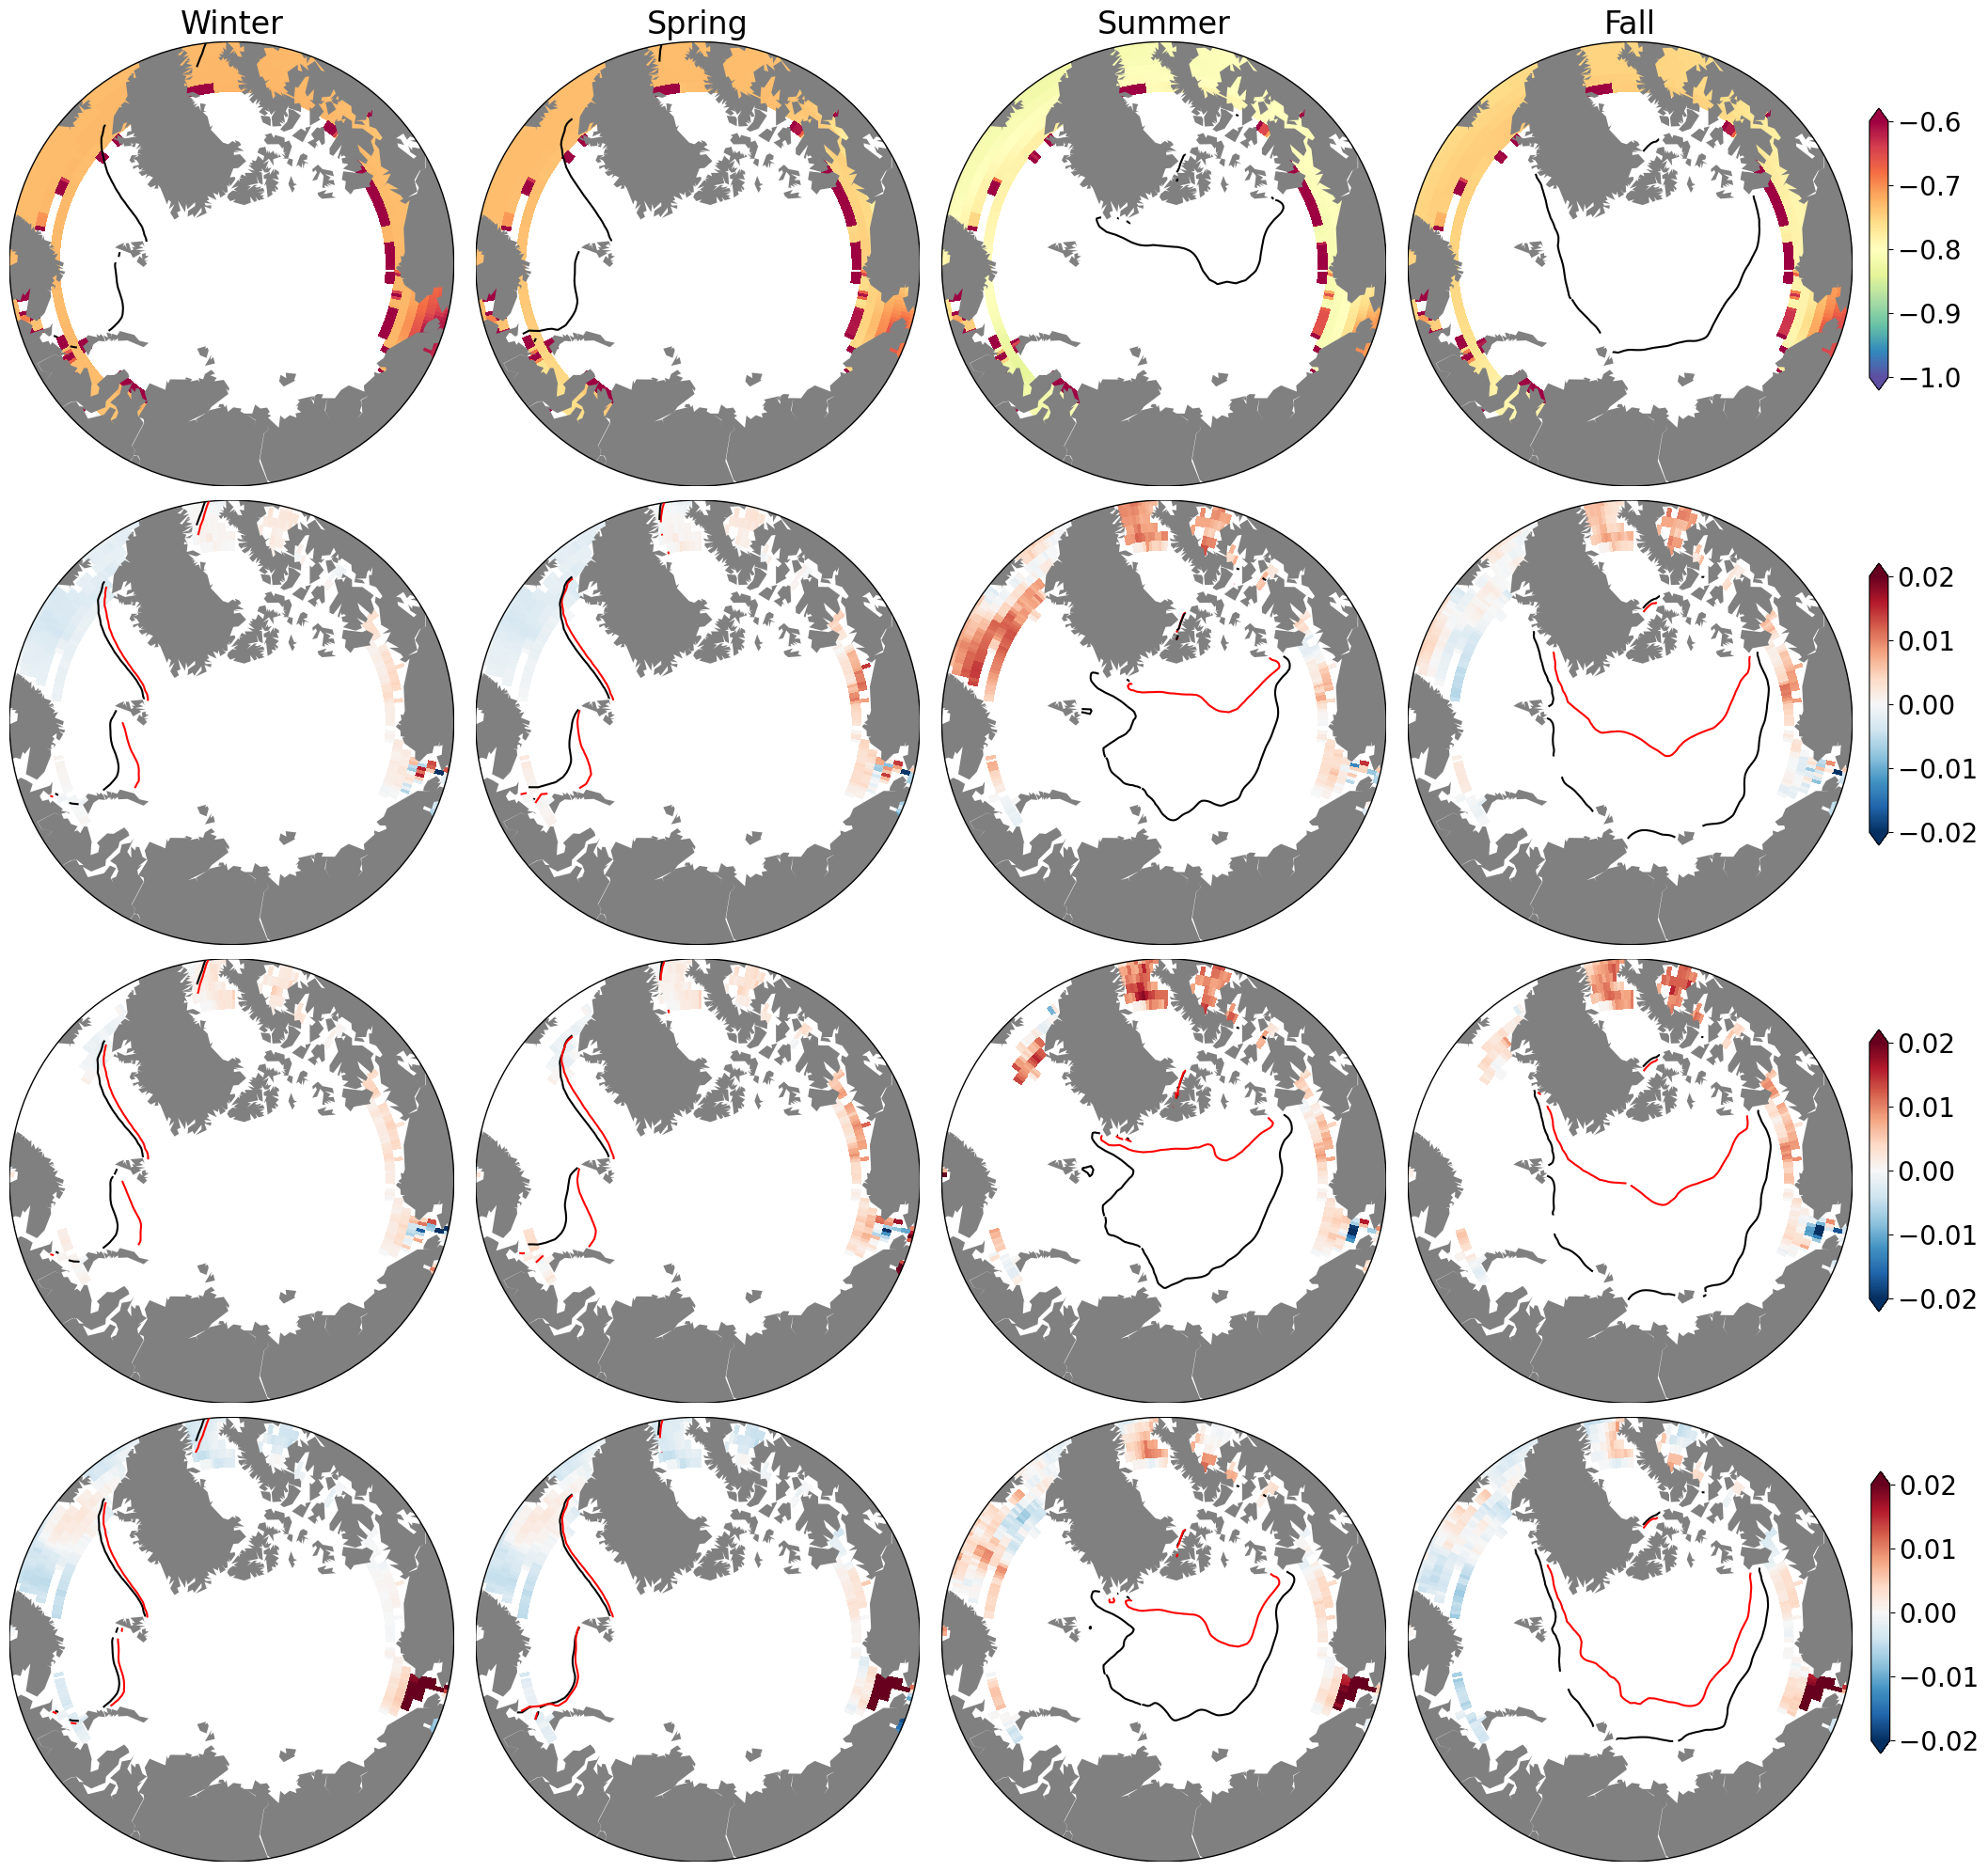

In [103]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))
lat = ds_03.lat

####################### 62 year averages ###############################
vminn=-1
vmaxx=-0.6
# Winter 
ax = fig.add_subplot(4, 4, 1)
winter, lon = add_cyclic_point(np.nanmean(slope[:,list(range(2)) + [-1],:,:],axis=(0,1)), coord=ds_03.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
winter_ice, lon = add_cyclic_point(np.nanmean(ice_frac_winter, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, winter,  cmap='Spectral_r', vmin = vminn, vmax = vmaxx);
cs = m.contour(x, y, winter_ice,levels = [0.7],colors='k');
ax.set_title('Winter', fontsize =24)

# Spring 
ax = fig.add_subplot(4, 4, 2)
spring, lon = add_cyclic_point(np.nanmean(slope[:,2:5,:,:],axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice, lon = add_cyclic_point(np.nanmean(ice_frac_spring, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = vminn, vmax = vmaxx);
cs = m.contour(x, y, spring_ice,levels = [0.7],colors='k');
ax.set_title('Spring', fontsize =24)

# Summer 
ax = fig.add_subplot(4, 4, 3)
summer, lon = add_cyclic_point(np.nanmean(slope[:,5:8,:,:],axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice, lon = add_cyclic_point(np.nanmean(ice_frac_summer, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, summer, cmap='Spectral_r',vmin = vminn, vmax = vmaxx);
cs = m.contour(x, y, summer_ice,levels = [0.7],colors='k');
ax.set_title('Summer', fontsize =24)

# Fall 
ax = fig.add_subplot(4, 4, 4)
fall, lon = add_cyclic_point(np.nanmean(slope[:,8:11,:,:],axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice, lon = add_cyclic_point(np.nanmean(ice_frac_fall, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, fall, cmap='Spectral_r',vmin = vminn, vmax = vmaxx);
cs = m.contour(x, y, fall_ice,levels = [0.7],colors='k');
ax.set_title('Fall', fontsize =24)

cbar_ax = fig.add_axes([0.999, 0.79, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel('Phytoplankton biomass ($\mu$gC m$^{-3}$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

####################### Low - high temperature differences  ###############################
## Set the vmin and vmax values here: ## 
vminn=-0.02
vmaxx=0.02

# WINTER
ax = fig.add_subplot(4, 4, 5)
winter_temp_diff = np.nanmean(low_temp_years[list(range(2)) + [-1],:,:],axis=0)-np.nanmean(high_temp_years[list(range(2)) + [-1],:,:],axis=0)
w_diff, lon =  add_cyclic_point(winter_temp_diff, coord=ds_03.lon, axis=1)
winter_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
winter_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 


# SPRING
ax = fig.add_subplot(4, 4, 6)
spring_temp_diff = np.nanmean(low_temp_years[2:5,:,:],axis=0)-np.nanmean(high_temp_years[2:5,:,:],axis=0)
sp_diff, lon =  add_cyclic_point(spring_temp_diff, coord=ds_03.lon, axis=1)
spring_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='red'); # ice in warmer years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='k'); # ice in colder years 


# SUMMER
ax = fig.add_subplot(4, 4, 7)
summer_temp_diff = np.nanmean(low_temp_years[5:8,:,:],axis=0)-np.nanmean(high_temp_years[5:8,:,:],axis=0)
s_diff, lon =  add_cyclic_point(summer_temp_diff, coord=ds_03.lon, axis=1)
summer_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='red'); # ice in warmer years
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='k'); # ice in colder years 


# FALL 
ax = fig.add_subplot(4, 4, 8)
fall_temp_diff = np.nanmean(low_temp_years[8:11,:,:],axis=0)-np.nanmean(high_temp_years[8:11,:,:],axis=0)
f_diff, lon =  add_cyclic_point(fall_temp_diff, coord=ds_03.lon, axis=1)
fall_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='red'); #ice in warmer years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='k'); # ice in colder years 
cbar_ax = fig.add_axes([0.999, 0.548, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (cold-warm)', fontsize=20)
cb.ax.tick_params(labelsize=20)


##################################### Ice Fraction  ###################################
# WINTER
ax = fig.add_subplot(4, 4, 9)
winter_ice_diff = np.nanmean(high_ice_years[list(range(2)) + [-1],:,:],axis=0)-np.nanmean(low_ice_years[list(range(2)) + [-1],:,:],axis=0)
w_diff, lon =  add_cyclic_point(winter_ice_diff, coord=ds_03.lon, axis=1)
winter_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
winter_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low ice years 


# SPRING
ax = fig.add_subplot(4, 4, 10)
spring_ice_diff =np.nanmean(high_ice_years[2:5,:,:],axis=0)-np.nanmean(low_ice_years[2:5,:,:],axis=0)
sp_diff, lon =  add_cyclic_point(spring_ice_diff, coord=ds_03.lon, axis=1)
spring_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low ice years 


# SUMMER
ax = fig.add_subplot(4, 4, 11)
summer_ice_diff = np.nanmean(high_ice_years[5:8,:,:],axis=0)-np.nanmean(low_ice_years[5:8,:,:],axis=0)
s_diff, lon =  add_cyclic_point(summer_ice_diff, coord=ds_03.lon, axis=1)
summer_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low ice years

# FALL
ax = fig.add_subplot(4, 4, 12)
fall_ice_diff = np.nanmean(high_ice_years[8:11,:,:],axis=0)-np.nanmean(low_ice_years[8:11,:,:],axis=0)
f_diff, lon =  add_cyclic_point(fall_ice_diff, coord=ds_03.lon, axis=1)
fall_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high ice years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low ice years 

cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

######################## NO3 ###################################

# WINTER
ax = fig.add_subplot(4, 4, 13)
winter_no3_diff = np.nanmean(high_no3_years[list(range(2)) + [-1],:,:],axis=0)-np.nanmean(low_no3_years[list(range(2)) + [-1],:,:],axis=0)
winter_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
winter_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
w_diff, lon =  add_cyclic_point(winter_no3_diff, coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# SPRING
ax = fig.add_subplot(4, 4, 14)
spring_no3_diff = np.nanmean(high_no3_years[2:5,:,:],axis=0)-np.nanmean(low_no3_years[2:5,:,:],axis=0)
sp_diff, lon =  add_cyclic_point(spring_no3_diff, coord=ds_03.lon, axis=1)
spring_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high no3 years
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# SUMMER. 
ax = fig.add_subplot(4, 4, 15)
summer_no3_diff = np.nanmean(high_no3_years[5:8,:,:],axis=0)-np.nanmean(low_no3_years[5:8,:,:],axis=0)
s_diff, lon =  add_cyclic_point(summer_no3_diff, coord=ds_03.lon, axis=1)
summer_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# FALL
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = np.nanmean(high_no3_years[8:11,:,:],axis=0)-np.nanmean(low_no3_years[8:11,:,:],axis=0)
f_diff, lon =  add_cyclic_point(fall_no3_diff, coord=ds_03.lon, axis=1)
fall_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 


cbar_ax = fig.add_axes([0.9999, 0.065, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)
plt.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_slope_quarterly_interannual_diff_1deg.png',dpi=600, bbox_inches='tight')

## Intercept for the size abundance relationship 

In [104]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years = np.empty([12,180,360]) ; low_no3_years[:] = np.nan
high_no3_years = np.empty([12,180,360]) ; high_no3_years[:] = np.nan

low_temp_years = np.empty([12,180,360]) ; low_temp_years[:] = np.nan
high_temp_years = np.empty([12,180,360]) ; high_temp_years[:] = np.nan

low_ice_years = np.empty([12,180,360]) ; low_ice_years[:] = np.nan
high_ice_years = np.empty([12,180,360]) ; high_ice_years[:] = np.nan


for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_no3_years[:,latitude,longitude] = np.nanmean(intercept[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_no3_years[:,latitude,longitude] = np.nanmean(intercept[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1)) 
        
        low_temp_years[:,latitude,longitude] = np.nanmean(intercept[cold_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_temp_years[:,latitude,longitude] = np.nanmean(intercept[warm_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        
        low_ice_years[:,latitude,longitude] = np.nanmean(intercept[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_ice_years[:,latitude,longitude] = np.nanmean(intercept[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

CPU times: user 2.62 s, sys: 10.6 ms, total: 2.63 s
Wall time: 2.7 s


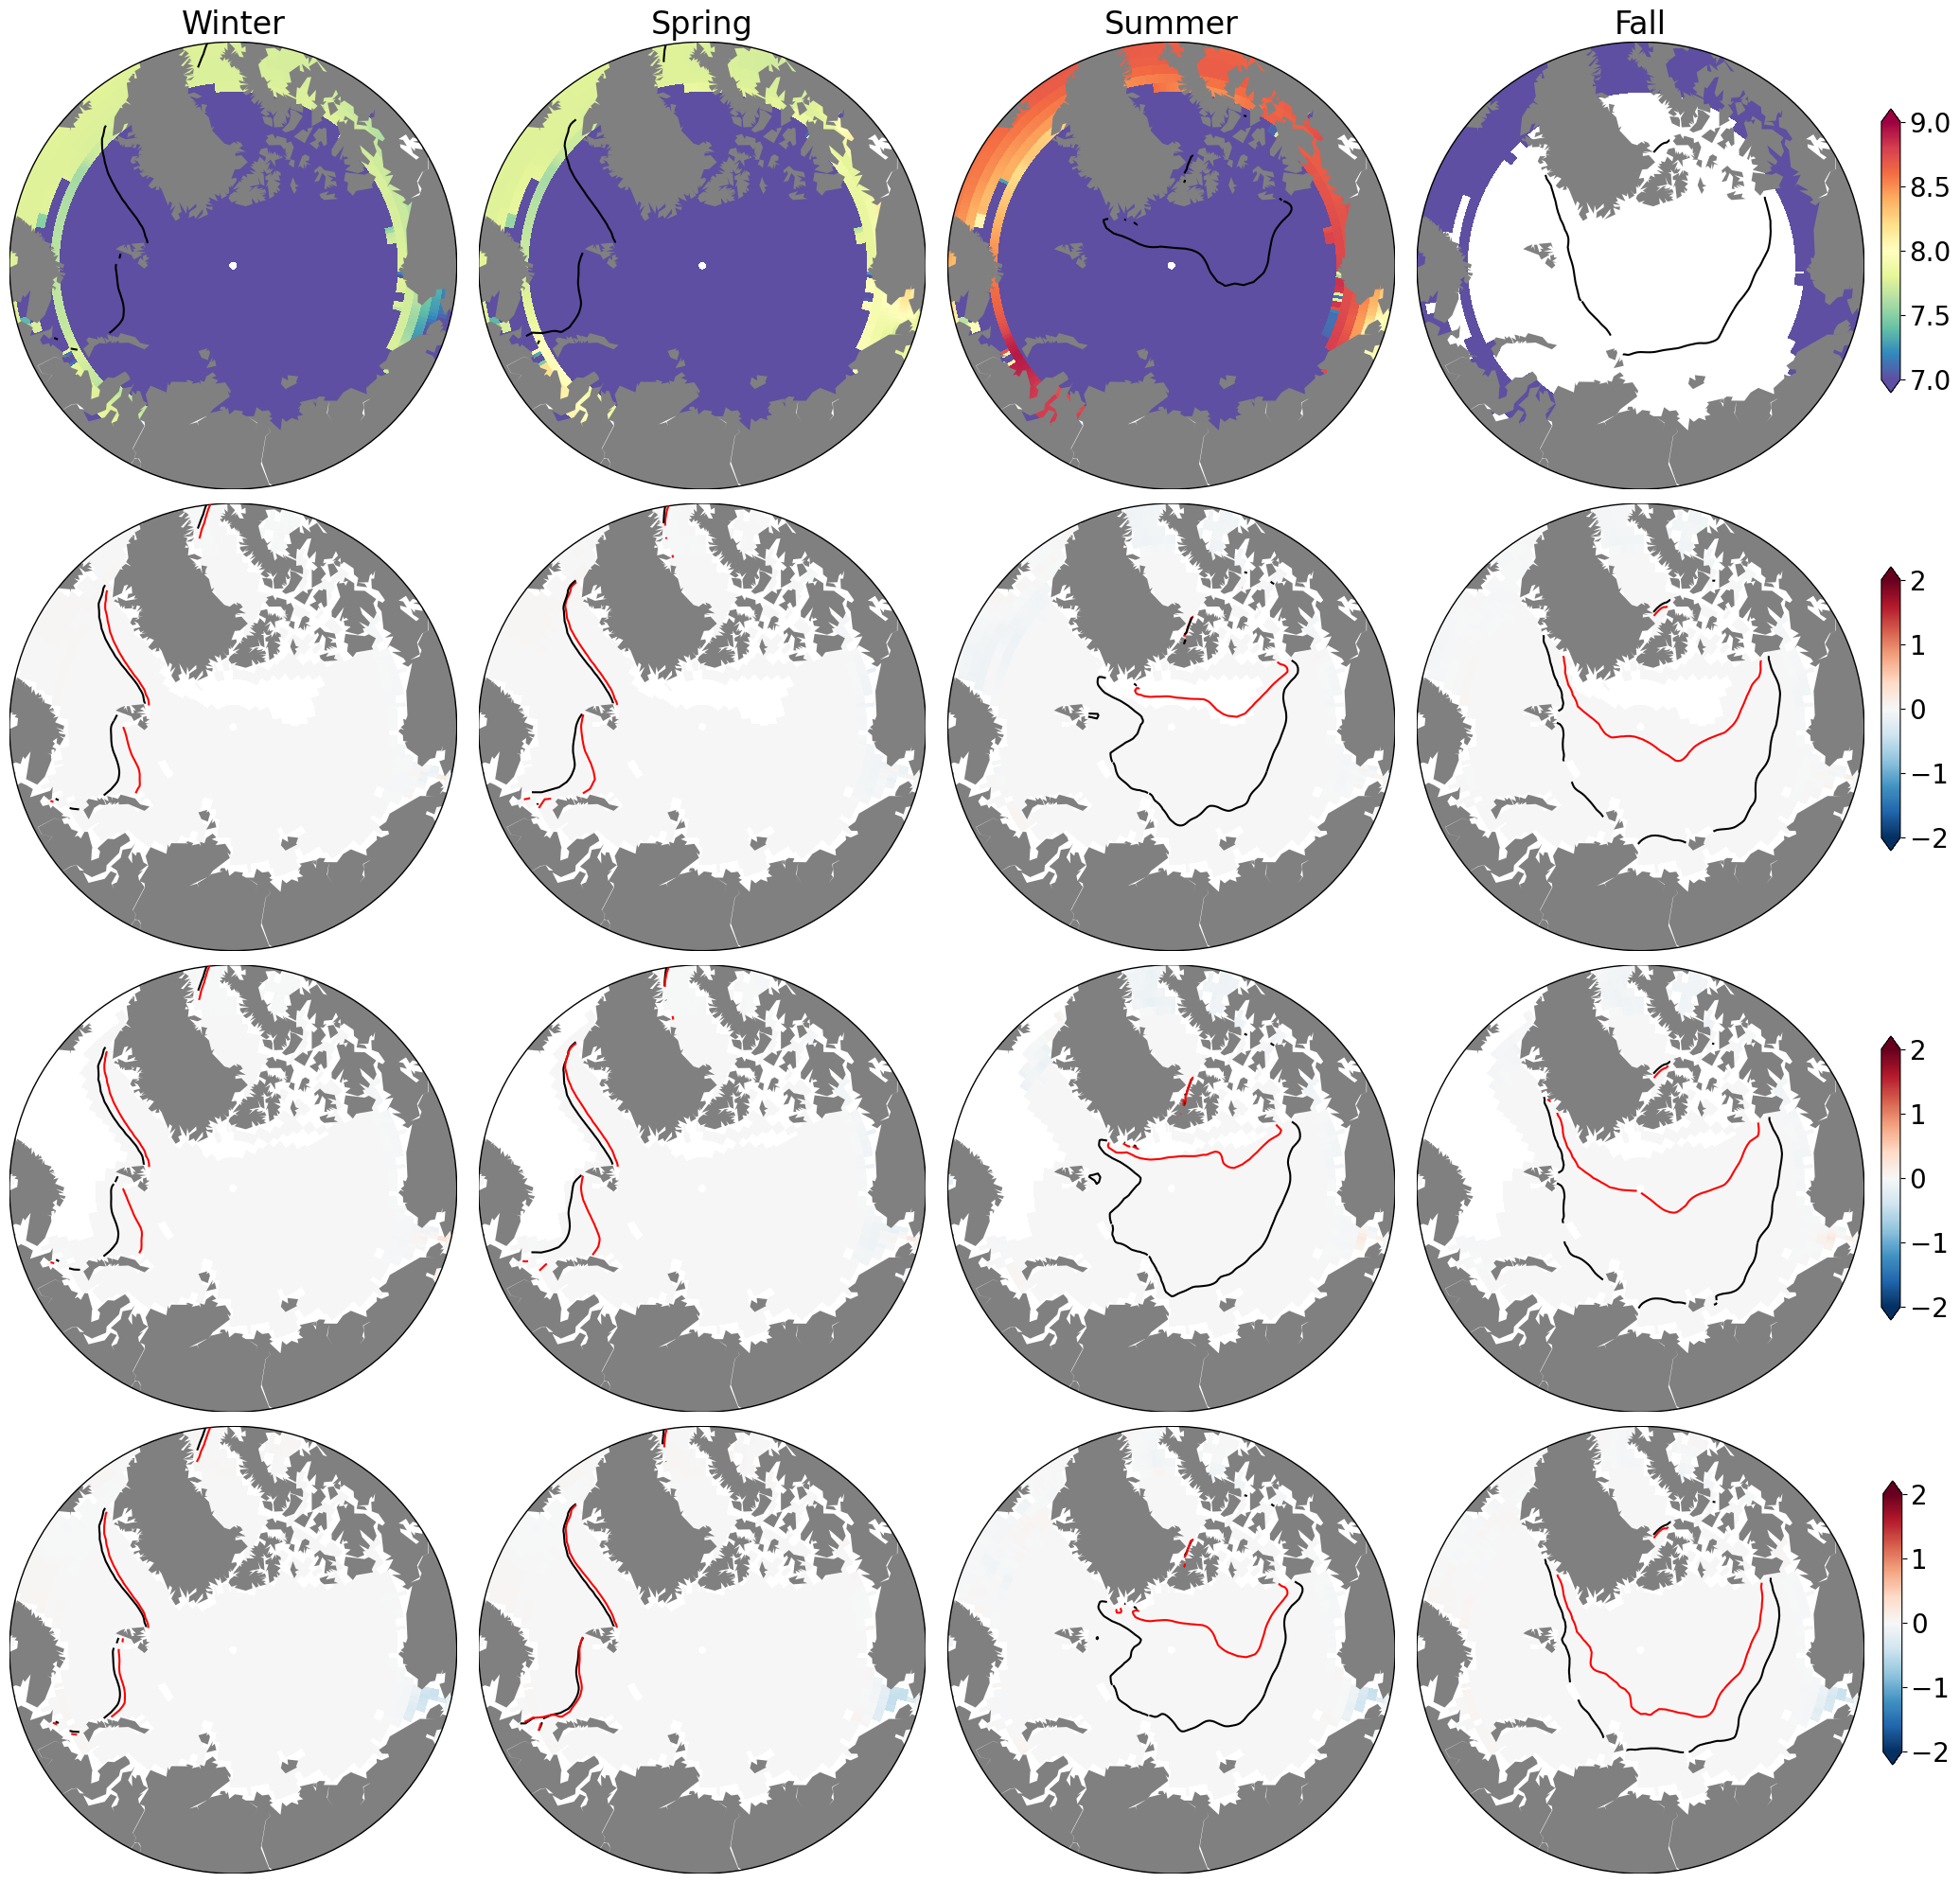

In [105]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))
lat = ds_03.lat

####################### 62 year averages ###############################
vminn=7
vmaxx=9
# Winter 
ax = fig.add_subplot(4, 4, 1)
winter, lon = add_cyclic_point(np.nanmean(intercept[:,list(range(2)) + [-1],:,:],axis=(0,1)), coord=ds_03.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
winter_ice, lon = add_cyclic_point(np.nanmean(ice_frac_winter, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, winter,  cmap='Spectral_r', vmin = vminn, vmax = vmaxx);
cs = m.contour(x, y, winter_ice,levels = [0.7],colors='k');
ax.set_title('Winter', fontsize =24)

# Spring 
ax = fig.add_subplot(4, 4, 2)
spring, lon = add_cyclic_point(np.nanmean(intercept[:,2:5,:,:],axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice, lon = add_cyclic_point(np.nanmean(ice_frac_spring, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = vminn, vmax = vmaxx);
cs = m.contour(x, y, spring_ice,levels = [0.7],colors='k');
ax.set_title('Spring', fontsize =24)

# Summer 
ax = fig.add_subplot(4, 4, 3)
summer, lon = add_cyclic_point(np.nanmean(intercept[:,5:8,:,:],axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice, lon = add_cyclic_point(np.nanmean(ice_frac_summer, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = vminn, vmax = vmaxx);
cs = m.contour(x, y, summer_ice,levels = [0.7],colors='k');
ax.set_title('Summer', fontsize =24)

# Fall 
ax = fig.add_subplot(4, 4, 4)
fall, lon = add_cyclic_point(np.nanmean(slope[:,8:11,:,:],axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice, lon = add_cyclic_point(np.nanmean(ice_frac_fall, axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, fall, cmap='Spectral_r', vmin = vminn, vmax = vmaxx);
cs = m.contour(x, y, fall_ice,levels = [0.7],colors='k');
ax.set_title('Fall', fontsize =24)

cbar_ax = fig.add_axes([0.999, 0.79, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel('Phytoplankton biomass ($\mu$gC m$^{-3}$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

####################### Low - high temperature differences  ###############################
## Set the vmin and vmax values here: ## 
vminn=-2
vmaxx=2

# WINTER
ax = fig.add_subplot(4, 4, 5)
winter_temp_diff = np.nanmean(low_temp_years[list(range(2)) + [-1],:,:],axis=0)-np.nanmean(high_temp_years[list(range(2)) + [-1],:,:],axis=0)
w_diff, lon =  add_cyclic_point(winter_temp_diff, coord=ds_03.lon, axis=1)
winter_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
winter_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 


# SPRING
ax = fig.add_subplot(4, 4, 6)
spring_temp_diff = np.nanmean(low_temp_years[2:5,:,:],axis=0)-np.nanmean(high_temp_years[2:5,:,:],axis=0)
sp_diff, lon =  add_cyclic_point(spring_temp_diff, coord=ds_03.lon, axis=1)
spring_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='red'); # ice in warmer years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='k'); # ice in colder years 


# SUMMER
ax = fig.add_subplot(4, 4, 7)
summer_temp_diff = np.nanmean(low_temp_years[5:8,:,:],axis=0)-np.nanmean(high_temp_years[5:8,:,:],axis=0)
s_diff, lon =  add_cyclic_point(summer_temp_diff, coord=ds_03.lon, axis=1)
summer_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='red'); # ice in warmer years
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='k'); # ice in colder years 


# FALL 
ax = fig.add_subplot(4, 4, 8)
fall_temp_diff = np.nanmean(low_temp_years[8:11,:,:],axis=0)-np.nanmean(high_temp_years[8:11,:,:],axis=0)
f_diff, lon =  add_cyclic_point(fall_temp_diff, coord=ds_03.lon, axis=1)
fall_ice_low, lon = add_cyclic_point(np.nanmean(low_temp_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice_high, lon = add_cyclic_point(np.nanmean(high_temp_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='red'); #ice in warmer years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='k'); # ice in colder years 
cbar_ax = fig.add_axes([0.999, 0.548, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (cold-warm)', fontsize=20)
cb.ax.tick_params(labelsize=20)


##################################### Ice Fraction  ###################################
# WINTER
ax = fig.add_subplot(4, 4, 9)
winter_ice_diff = np.nanmean(high_ice_years[list(range(2)) + [-1],:,:],axis=0)-np.nanmean(low_ice_years[list(range(2)) + [-1],:,:],axis=0)
w_diff, lon =  add_cyclic_point(winter_ice_diff, coord=ds_03.lon, axis=1)
winter_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
winter_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low ice years 


# SPRING
ax = fig.add_subplot(4, 4, 10)
spring_ice_diff =np.nanmean(high_ice_years[2:5,:,:],axis=0)-np.nanmean(low_ice_years[2:5,:,:],axis=0)
sp_diff, lon =  add_cyclic_point(spring_ice_diff, coord=ds_03.lon, axis=1)
spring_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low ice years 


# SUMMER
ax = fig.add_subplot(4, 4, 11)
summer_ice_diff = np.nanmean(high_ice_years[5:8,:,:],axis=0)-np.nanmean(low_ice_years[5:8,:,:],axis=0)
s_diff, lon =  add_cyclic_point(summer_ice_diff, coord=ds_03.lon, axis=1)
summer_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low ice years

# FALL
ax = fig.add_subplot(4, 4, 12)
fall_ice_diff = np.nanmean(high_ice_years[8:11,:,:],axis=0)-np.nanmean(low_ice_years[8:11,:,:],axis=0)
f_diff, lon =  add_cyclic_point(fall_ice_diff, coord=ds_03.lon, axis=1)
fall_ice_low, lon = add_cyclic_point(np.nanmean(low_ice_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice_high, lon = add_cyclic_point(np.nanmean(high_ice_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high ice years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low ice years 

cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

######################## NO3 ###################################

# WINTER
ax = fig.add_subplot(4, 4, 13)
winter_no3_diff = np.nanmean(high_no3_years[list(range(2)) + [-1],:,:],axis=0)-np.nanmean(low_no3_years[list(range(2)) + [-1],:,:],axis=0)
winter_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
winter_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_winter_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
w_diff, lon =  add_cyclic_point(winter_no3_diff, coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# SPRING
ax = fig.add_subplot(4, 4, 14)
spring_no3_diff = np.nanmean(high_no3_years[2:5,:,:],axis=0)-np.nanmean(low_no3_years[2:5,:,:],axis=0)
sp_diff, lon =  add_cyclic_point(spring_no3_diff, coord=ds_03.lon, axis=1)
spring_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
spring_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_spring_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high no3 years
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# SUMMER. 
ax = fig.add_subplot(4, 4, 15)
summer_no3_diff = np.nanmean(high_no3_years[5:8,:,:],axis=0)-np.nanmean(low_no3_years[5:8,:,:],axis=0)
s_diff, lon =  add_cyclic_point(summer_no3_diff, coord=ds_03.lon, axis=1)
summer_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
summer_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_summer_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# FALL
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = np.nanmean(high_no3_years[8:11,:,:],axis=0)-np.nanmean(low_no3_years[8:11,:,:],axis=0)
f_diff, lon =  add_cyclic_point(fall_no3_diff, coord=ds_03.lon, axis=1)
fall_ice_low, lon = add_cyclic_point(np.nanmean(low_no3_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
fall_ice_high, lon = add_cyclic_point(np.nanmean(high_no3_years_fall_ice, axis=(0,1)), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 


cbar_ax = fig.add_axes([0.9999, 0.065, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)
plt.tight_layout()
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_intercept_quarterly_interannual_diff_1deg.png',dpi=600, bbox_inches='tight')